<a href="https://colab.research.google.com/github/Improbable-AI/csl-assignments/blob/main/hw2/hw/Homework_on_Value_and_Policy_Iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spring 2024 6.8200 Computational Sensorimotor Learning Assignment 7

In this assignment, we will implement three principle reinforcement learning algorithms which provably converge to optimal solutions for MDPs:


*   Value iteration
*   Policy iteration
*   Q-learning

You will need to <font color='blue'>answer the bolded questions</font> and <font color='blue'>fill in the missing code snippets (marked by **TODO**)</font>.

There are **229** total points to be had in this PSET.  `ctrl-f` for "pts" to ensure you don't miss questions.

**When submitting, DO NOT add your kerberos or your name to the title of your submission or your submission file!**


### Credits

Some part of the code of this assignment is borrowed from the Spring 2018 CMU Deep Reinforcement Learning & Control course. We also thank Prof. [Cathy Wu](https://idss.mit.edu/staff/cathy-wu/) for polishing the content.

## Setup

The following code sets up imports and helper functions (you can ignore this).

In [ ]:
%matplotlib inline
import numpy as np
import random
import time
import os
import gym
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd


from copy import deepcopy
from tqdm.notebook import tqdm
from dataclasses import dataclass
from matplotlib import animation
from IPython.display import HTML
from typing import Any
from collections import deque

mpl.rcParams['figure.dpi']= 100

In [ ]:
# some util functions
def plot(logs, x_key, y_key, legend_key, **kwargs):
    nums = len(logs[legend_key].unique())
    palette = sns.color_palette("hls", nums)
    if 'palette' not in kwargs:
        kwargs['palette'] = palette
    sns.lineplot(x=x_key, y=y_key, data=logs, hue=legend_key, **kwargs)

def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

# set random seed
seed = 0
set_random_seed(seed=seed)

# FrozenLake environment

*Winter has come.* You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.

The surface is described using a grid like the following:

```
SFFF # (S: starting point, safe)
FHFH # (F: frozen surface, safe)
FFFH # (H: hole, fall to your doom)
HFFG # (G: goal, where the frisbee is located)
```

The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.

Here's what the Frozen Lake looks like in action, when following a random agent:

![](https://miro.medium.com/max/690/1*ur_42c7MLhbi6q2L3JtSqg.gif)

Frozen Lake is part of OpenAI gym, a collection of open-source environments for benchmarking RL algorithms.   [Here](https://gym.openai.com/envs/FrozenLake-v0/) is a link to the gym environment (also the source of our environment description).

**Question:** how many actions can the agent take at any time; eg, what is the size of the action space? (2 pts)

**Answer:** Up, Down, Left, Right: total 4

Now, here's some code that creates the above environment through OpenAI gym, called `FrozenLake-v0`.  Note that we will be using a deterministic variant, so providing an action in a given direction will always move you in that direction.

In [ ]:
## create FrozenLake environment
MAPS = {
    "4x4": [
        "GHFS",
        "FHHF",
        "FFHF",
        "FFFF"
    ],
    "8x8": [
        "FFFSFFFF",
        "FFFFFFFF",
        "HHHHFHFF",
        "FFFFFFHF",
        "FFFFFFFF",
        "FHFFFFHF",
        "FHFFHFHH",
        "FGHFFFFF"
    ],
}
from gym.envs.registration import register
env_name = 'Deterministic-4x4-FrozenLake-v0'
if env_name not in gym.envs.registry.env_specs:
    register(
        id=env_name,
        entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
        kwargs={'map_name': None,
                'is_slippery': False,
                'desc': MAPS['4x4']
                },
        max_episode_steps=20)

env_name = 'Deterministic-8x8-FrozenLake-v0'
if env_name not in gym.envs.registry:
    register(
        id=env_name,
        entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
        kwargs={'map_name': None,
                'is_slippery': False,
                'desc': MAPS['8x8'],
                },
        max_episode_steps=100)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(


We would like to find a good policy for the agent (you, the brave soul). More precisely, the agent controls the movement of a character on the frozen lake. The frozen lake environment is an example of a _grid world_, since it consists of objects moving around in a discrete (grid) world. Grid world problems can constitute or approximate a wide class of problems.

**Question:** Consider a racecar environment, where the goal is to get the agent (the racecar) around a race track as quickly as possible. Is this suitable for representing as a grid world problem?  Justify your answer. (4 pts)

**Answer:** The reward is 1 only when we arrive at the goal. Therefore there is no need to get there quick. Therefore it is different from the race.

Now let's return to the task at hand: retrieving our frisbee!
Remember that some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

Now let's consider some algorithms for solving this problem, i.e. finding a good policy to accomplish the task.

# Value Iteration

Value iteration is the first algorithm we will consider.

Let's first do a sanity check:

**Question:** Consider a fixed 4x4-grid FrozenLake. What is the size of the state space? (4 pts)

**Answer:** 16

Now recall from class that value iteration is a method which starts with any guess of a value function $V_0$ and then updates it according to the optimal Bellman equation: $V_{i+1}(s) = \mathcal{T} V_i(s) = \max_a \mathbb{E}_{s' \sim p(\cdot | s, a)}[r(s, a, s') + \gamma V_i(s')]$.  In our case, as we have a fixed number of states, our value function is simply a mapping of square -> value (eg an array).

*Note:* we choose to represent actions as integers with the following mapping:

```
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
```

and states as zero-indexed integers traversing from the top left.

## Implement Value Iteration

*(20 pts)*

We will now implement value iteration over the MDP with transition probabilities described by `env.P` (transition probabilites). 'env.P` is an $N$x$M$ 2D array, with $N$ being the number of states and $M$ being the number of actions.  

Each entry `env.P[s][a]` (where `s` is the state index and `a` is the action index) is a list of transition tuples $(p(s,a,s'), s', r(s, a, s'), \text{episode_end})$ for each list index index `s'`.  In plain english:

 - $p(s,a,s')$: the probability of transitioning to state `s'` after taking action `a` in state `s`.
 - $s'$: the next state under this transition.
 - $r(s, a, s')$: the reward of taking this transition.
 - `episode_end`: a boolean representing whether taking this action ends the episode (in Frozen lLke, whether this kills you or takes you to the goal position).

In [ ]:
def value_iteration(env, gamma, max_iterations=1000, tol=1e-3):
    """Runs value iteration for a given gamma and environment.
    Updates states in their 1-N order.
    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for.
    gamma: float
      Discount factor, must be in range [0, 1)
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.
    Returns
    -------
    np.ndarray, iteration, list
      The value function, the number of iterations it took to converge, and a list
      of the value functions after each iteration.
    """
    value_func = np.zeros(len(env.P)) # initial value function: all states are zero
    policy = np.zeros(len(env.P), dtype='int') # placeholder for computed policy
    iters = 0
    value_history = []
    while True:
        delta = 0 # the difference between the current value to the new one (in the state we updated), used for stoping criteria. See lecture notes 9.1.2, Algorithm 12, line 5.
        ###### TODO: Update the value function and store it in value_func (array). ##############

        value_i = value_func.copy()

        for state in range(len(env.P)):
            max_action = np.argmax([env.P[state][action][0][2] + gamma*value_i[env.P[state][action][0][1]] for action in range(4)])
            next_state = env.P[state][max_action][0][1]
            value_func[state] = env.P[state][max_action][0][2] + gamma*value_i[next_state]

            ### In this case because we have initialized the value function zero, the value function of the next state of the hole or goal
            ### will be automatically zero. So we don't have to separate hole and goal cases.

        delta = np.max(np.abs(value_func - value_i))
        ################################################################

        # let's also save a copy of value function after each iteration
        value_history.append(value_func.copy())
        iters += 1
        if delta < tol or iters >= max_iterations:
            break
    return value_func, iters, value_history


Actually, computing the optimal value function is not enough. What we are interested in is the optimal policy, not just how good each state is. Luckily, the optimal value function and the optimal policy are related. Let's implement this next:

*(15 pts)*

In [ ]:
def value_function_to_policy(env, gamma, value_function):
    """Output action numbers for each state in value_function.
    Parameters
    ----------
    env: gym.core.Environment
      Environment to compute policy for. Must have nS, nA, and P as
      attributes.
    gamma: float
      Discount factor. Number in range [0, 1)
    value_function: np.ndarray
      Value of each state.
    Returns
    -------
    np.ndarray
      An array of integers. Each integer is the optimal action to take
      in that state according to the environment dynamics and the
      given value function.
    """
    policy = np.zeros(len(env.P), dtype='int')
    for idx in range(len(env.P)):
        vmax = -np.inf
        best_act = -1
        ###### TODO: Select the best action (best_act) ##############
        ## Hint: You can use env.P to get the action idxs and infos.
        for act in range(4):
            v = env.P[idx][act][0][2] + gamma*value_function[env.P[idx][act][0][1]]
            if v > vmax:
                vmax = v
                best_act = act
        ###################################################

        policy[idx] = best_act
    return policy



**Question**: What is the difference between the value iteration algorithm and extracting a policy from a value function? (4 pts)

**Answer**: Value iteration algorithm finds the maximum of expectation value over next states. Policy extraction finds the maximum expectation value over the policy. In this case, we are dealing with deterministic policy, they work equivalently

OK enough talk, let's run it. We'll consider this 8x8 frozen lake:

```
FFFSFFFF
FFFFFFFF
HHHHFHFF
FFFFFFHF
FFFFFFFF
FHFFFFHF
FHFFHFHH
FGHFFFFF
```

## Run Value Iteration

Print and plot your computed value and policy functions as 8x8 2D grids.  Your policy should look something like this:

```
XXXXXXXX
XXXXXXXX
...
XXXXXXXX
```

where `X` is the optimal action in that state (one of `L`, `R`, `U`, `D`).  Your value function should look similar, except containing space-separated floats rather than action characters.


In [ ]:
def print_policy(policy):
    act_dict = {0: 'L', 1: 'D', 2: 'R', 3: 'U'}
    row = col = int(np.sqrt(policy.size))
    for i in range(row):
        for j in range(col):
            print(act_dict[policy[i * col + j]], end='')
        print('')


def print_value(value):
    row = col = int(np.sqrt(value.size))
    for i in range(row):
        for j in range(col):
            print('{0:.6f}'.format(value[i * col + j]), end=' ')
        print('')

def plot_value_history(value_history):
    row = col = int(np.sqrt(value_history[0].size))
    images = [x.reshape(row, col) for x in value_history]

    num_images = len(images)
    cols = int(np.sqrt(num_images))
    rows = int(np.ceil(num_images / cols))
    fig = plt.figure(figsize=(5, 12))
    for i, image in enumerate(images):
        plt.subplot(rows + 1, cols, i + 1)
        plt.imshow(image)
        plt.xlabel(f'Iter: {i}')
    fig.tight_layout()

In [ ]:
env = gym.make('Deterministic-8x8-FrozenLake-v0')
env.reset()

gamma = 0.9
value_info = value_iteration(env, gamma, max_iterations=int(1e3), tol=1e-4)
value, iters, value_history = value_info
policy = value_function_to_policy(env, gamma, value)
print('Policy: ')
print_policy(policy)
print('Value: ')
print_value(value)
print('Iterations: ', iters)

Policy: 
DDDDDLLL
RRRRDLLL
LLLLDLRD
DLLLLLLD
DLLLLLLL
DLULLLLU
DLULLULL
RLLULLLL
Value: 
0.205891 0.228768 0.254187 0.282430 0.313811 0.282430 0.254187 0.228768 
0.228768 0.254187 0.282430 0.313811 0.348678 0.313811 0.282430 0.254187 
0.000000 0.000000 0.000000 0.000000 0.387420 0.000000 0.254187 0.282430 
0.656100 0.590490 0.531441 0.478297 0.430467 0.387420 0.000000 0.313811 
0.729000 0.656100 0.590490 0.531441 0.478297 0.430467 0.387420 0.348678 
0.810000 0.000000 0.531441 0.478297 0.430467 0.387420 0.000000 0.313811 
0.900000 0.000000 0.478297 0.430467 0.000000 0.348678 0.000000 0.000000 
1.000000 0.000000 0.000000 0.387420 0.348678 0.313811 0.282430 0.254187 
Iterations:  17


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
row = col = int(np.sqrt(value_history[0].size))
images = [x.reshape(row, col) for x in value_history]
num_images = len(images)
len(value_history)

17

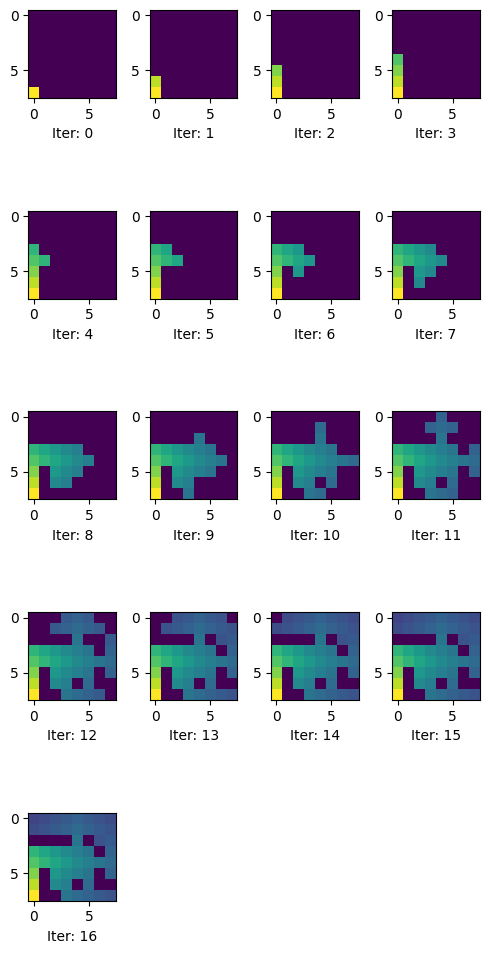

In [ ]:
plot_value_history(value_history)

Policy: 
LLLLLLLL
LLLLLLLL
LLLLDLLL
DLLLLLLL
DLLLLLLL
DLULLLLL
DLULLLLL
RLLULLLL
Value: 
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.008100 0.002430 0.000729 0.000219 0.000066 0.000000 0.000000 0.000000 
0.027000 0.008100 0.002430 0.000729 0.000219 0.000066 0.000000 0.000000 
0.090000 0.000000 0.000729 0.000219 0.000066 0.000000 0.000000 0.000000 
0.300000 0.000000 0.000219 0.000066 0.000000 0.000000 0.000000 0.000000 
1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
Iterations:  9


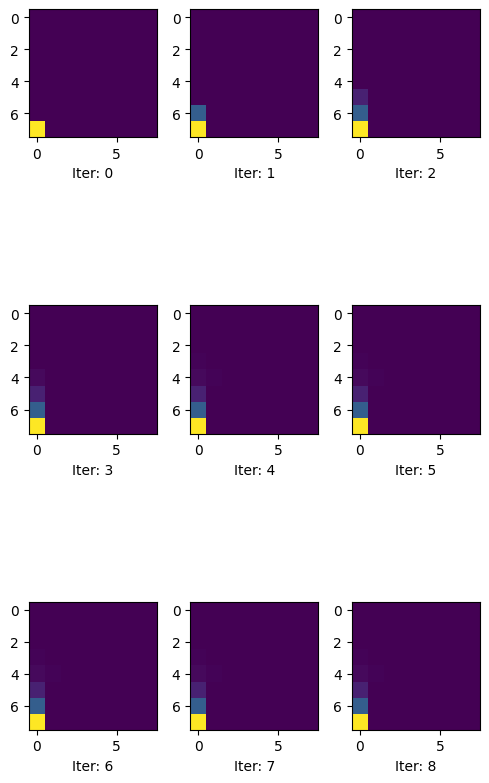

In [ ]:
env = gym.make('Deterministic-8x8-FrozenLake-v0')
env.reset()

gamma = 0.3
value_info = value_iteration(env, gamma, max_iterations=int(1e3), tol=1e-4)
value, iters, value_history = value_info
policy = value_function_to_policy(env, gamma, value)
print('Policy: ')
print_policy(policy)
print('Value: ')
print_value(value)
print('Iterations: ', iters)

row = col = int(np.sqrt(value_history[0].size))
images = [x.reshape(row, col) for x in value_history]
num_images = len(images)
len(value_history)

plot_value_history(value_history)

**Question**: Answers/observe the following *(3 pts each, 18 pts overall)*:

- Has the agent found a successful policy? (hint: it should have.)  How do you know?
  - **Answer**: yes. given the final policy it reaches the goal.

- Does the value function seem reasonable? Please explain.
  - **Answer**: yes. The value function becomes larger as it is closer to the goal.

- How many steps of value iteration were required convergence?
  - **Answer**: 17

- How many steps does the agent take to reach the goal location?
  - **Answer**: 17


- Try running the above code with gamma = 0.3.  Does the agent converge to a successful policy (yes/no)?
  - **Answer**: No

- If yes, then why does gamma have no effect? If no, then why does gamma matter?
  - **Answer**: Because if gamma is too small, the discounted reward with accumulated gamma that updates the value function near the start point becomes very small, which cannot update the value correctly to find a optimal action.

# Policy Iteration

Recall from class that value iteration is a special instance of generalized policy iteration, which alternates between 1 step of policy evaluation and 1 step of policy improvement.

Now we'll consider policy iteration, which alternates between many steps of policy evaluation and 1 step of policy improvement.

We will make a few notes:
- Let's consider N steps of policy evaluation + 1 step of policy improvement to be 1 iteration of value/policy iteration.
- It is not well understood why, but policy iteration and value iteration will attain the optimal policy in fewer iterations for different problems (see chapter 4 [here](http://incompleteideas.net/book/RLbook2020.pdf)).
- While policy iteration has a hidden cost of N policy evaluation steps, it turns out that a full policy evaluation can be computed efficiently, since it is a linear operation. (We will not do this in this assignment, but trust us.) If employed efficiently, policy iteration can be viewed as a super-powered value iteration, with accurate policy evaluation and without a whole lot of extra computational cost.

Now, let's implement policy evaluation and policy improvement.

## Implement Policy Iteration

*(15 pts)*

First, implement the the high level wrapper `policy_iteration`, which evaluates a policy to obtain a `value_func` and feeds that into `improve_policy` to update the policy in a loop.  Remember to end iteration once the policy is stable.

In [ ]:
def policy_iteration(env, gamma, max_iterations=int(1e3), tol=1e-3):
    """Runs policy iteration using the improve_policy and evaluate_policy methods.

    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    gamma: float
      Discount factor, must be in range [0, 1)
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.
    Returns
    -------
    (np.ndarray, np.ndarray, int, int, list)
       Returns optimal policy, value function, number of policy
       improvement iterations, number of value iterations, and a list
       of the history value functions.
    """
    policy = np.zeros(len(env.P), dtype='int')
    value_history = [] # should contain the value func after each policy iteration.
    policy_imp_step = 0 # number of total policy iterations
    policy_eval_step = 0 # number of total value iterations
    while True:
        ### TODO: Fill in policy iteration main loop. ##########
        value_func, eval_step = evaluate_policy(env, gamma, policy, max_iterations, tol)
        policy_eval_step += eval_step

        policy_stable, new_policy = improve_policy(env, gamma, value_func, policy)
        policy_imp_step += 1

        policy = new_policy.copy()
        value_history.append(value_func.copy())

        if policy_stable:
            break

        ##########################################################
    return policy, value_func, policy_imp_step, policy_eval_step, value_history

Next, implement the policy evaluation and update submethods.

*(25 pts)*


In [ ]:
def evaluate_policy(env, gamma, policy, max_iterations=int(1e3), tol=1e-3):
    """Performs policy evaluation.
    Evaluates the value of a given policy by asynchronous DP.  Updates states in
    their 1-N order.
    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for.
    gamma: float
      Discount factor, must be in range [0, 1)
    policy: np.array
      The policy to evaluate. Maps states to actions.
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.
    Returns
    -------
    np.ndarray, int
      The value for the given policy and the number of iterations till
      the value function converged.
    """
    value_func = np.zeros(len(env.P))
    iter = 0
    while True:
        delta = 0
        ###### TODO: value function update (value_func) ##############
        value_i = value_func.copy()

        for state in range(len(env.P)):
            next_state = env.P[state][policy[state]][0][1]
            value_func[state] = env.P[state][policy[state]][0][2] + gamma*value_i[next_state]

        delta = np.max(np.abs(value_func - value_i))
        ###################################################

        iter += 1
        if delta < tol or iter >= max_iterations:
            break
    return value_func, iter

def improve_policy(env, gamma, value_func, policy):
    """Performs policy improvement.
    Given a policy and value function, improves the policy.
    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    gamma: float
      Discount factor, must be in range [0, 1)
    value_func: np.ndarray
      Value function for the given policy.
    policy: dict or np.array
      The policy to improve. Maps states to actions.
    Returns
    -------
    bool, np.ndarray
      Returns true if policy changed. Also returns the new policy.
    """
    policy_stable = True
    new_policy = np.zeros(len(env.P), dtype='int')
    for idx in range(len(env.P)):
        old_action = policy[idx]
        p = env.P[idx]
        new_action = -1
        best_q = -np.inf
        ###### TODO: use value function to get new action (new_action) ######
        for action in range(len(p)):
            q = p[action][0][2] + gamma * value_func[p[action][0][1]]
            if q > best_q:
                best_q = q
                new_action = action
        ###################################################

        new_policy[idx] = new_action
        if new_action != old_action:
            policy_stable = False
    return policy_stable, new_policy

## Run Policy Iteration

Assuming your above implementation is correct, you should be able to run the below code to evaluate policy iteration on Frozen Lake.

In [ ]:
env = gym.make('Deterministic-8x8-FrozenLake-v0')
gamma = 0.9
policy_info = policy_iteration(env, gamma, max_iterations=int(1e3), tol=1e-3)
new_policy, value_func, policy_imp_step, policy_eval_step, value_history = policy_info
policy = value_function_to_policy(env, gamma, value_func)
print('New policy: ')
print_policy(new_policy)
print('Value: ')
print_value(value_func)
print('Number of policy improvement steps: ', policy_imp_step)
print('Total number of policy evaluation steps: ', policy_eval_step)

New policy: 
DDDDDLLL
RRRRDLLL
LLLLDLRD
DLLLLLLD
DLLLLLLL
DLULLLLU
DLULLULL
RLLULLLL
Value: 
0.205891 0.228768 0.254187 0.282430 0.313811 0.282430 0.254187 0.228768 
0.228768 0.254187 0.282430 0.313811 0.348678 0.313811 0.282430 0.254187 
0.000000 0.000000 0.000000 0.000000 0.387420 0.000000 0.254187 0.282430 
0.656100 0.590490 0.531441 0.478297 0.430467 0.387420 0.000000 0.313811 
0.729000 0.656100 0.590490 0.531441 0.478297 0.430467 0.387420 0.348678 
0.810000 0.000000 0.531441 0.478297 0.430467 0.387420 0.000000 0.313811 
0.900000 0.000000 0.478297 0.430467 0.000000 0.348678 0.000000 0.000000 
1.000000 0.000000 0.000000 0.387420 0.348678 0.313811 0.282430 0.254187 
Number of policy improvement steps:  13
Total number of policy evaluation steps:  145


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


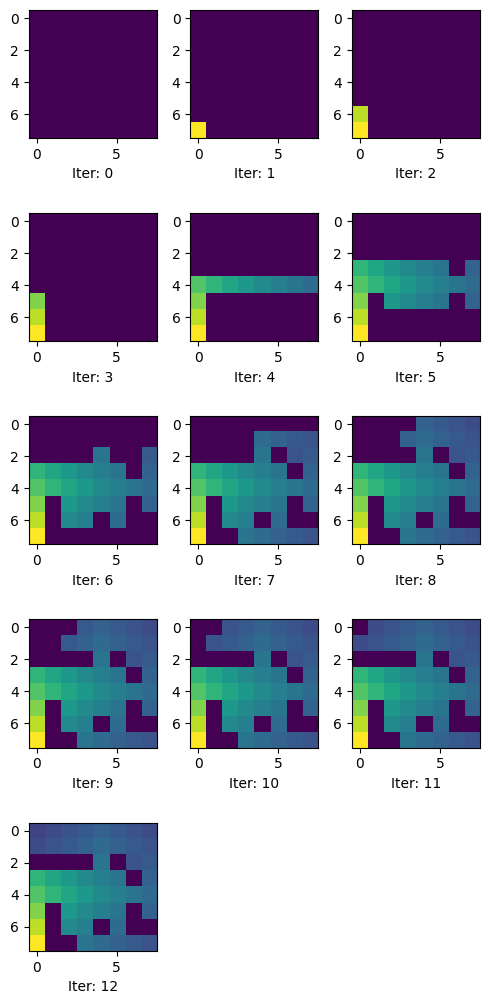

In [ ]:
plot_value_history(value_history)

Note that both value and policy iteration can solve the `Frozen Lake` environment (if one can't, you've done something wrong).

**Questions** *(4 pts each, 12 pts overall)*:
- How many iterations (i.e. policy improvement steps) were required by policy iteration?
  - **Answer:** 13
- How many policy improvement steps were required by value iteration?
  - **Answer:** 17
- If one method took longer to converge, postulate an explanation for this.
   - **Answer**: In this particular example, policy iteration took smaller steps. This might be because the evaluation takes more steps for policy iteration, making it a little bit more accurate and improvement faster.


One common benchmark for reinforcment learning algorithms is *sample complexity*: the number of interactions the agent must have with the environment to learn a policy.  In policy iteration, since we don't sample from the environment but instead using our direct access to the environment we can approximate this as the number of access we do to env.P

**Question**:  Compute the sample complexity to solve 8x8 FrozenLake.  What number do you get? (10 pts)

**Answer**: 64x145 (state space dim x total evaluation times) + 64x13 (state space dim x total policy improvment) = 10688

# Q-learning

In the above two algorithms, we had access to the entire MDP: all of the states, with all of the transition probabilities between them.  Unfortunately, this is usually not the case.

Below we will implement Q-learning, which is *model free*: it does not require full knowledge of environment dynamics, and instead will try to learn a policy purely through exploration and exploitation.

Fill in the missing functions in the `QLearningAgent` below.

*(50 pts)*

In [ ]:
@dataclass
class QLearningAgent:
    """
    A Q-Learning agent for reinforcement learning environments.

    Parameters
    ----------
    env : gym.Env
        The environment the agent will interact with. Must be compatible with OpenAI Gym interfaces.
    learning_rate : float
        The rate at which the agent learns from new experiences.
    gamma : float
        The discount factor used to balance immediate and future rewards. Must be in the range [0, 1).
    initial_epsilon : float
        The initial exploration rate. The probability of choosing a random action to explore the environment.
    min_epsilon : float
        The minimum exploration rate. Epsilon will decay to this value over `max_decay_episodes`.
    max_decay_episodes : int
        The number of episodes over which epsilon is decayed from `initial_epsilon` to `min_epsilon`.
    init_q_value : float, optional
        The initial value to assign to all Q-values. Defaults to 0.
    """
    env: gym.Env
    learning_rate: float
    gamma: float
    initial_epsilon: float
    min_epsilon: float
    max_decay_episodes: int
    init_q_value: float = 0.

    def __post_init__(self):
        self.num_states = self.env.observation_space.n
        self.reset()

    def decay_epsilon(self):
        ### TODO: decay epsilon, called after every episode ################
        self.epsilon = max(self.epsilon - self.ep_reduction, self.min_epsilon)
        #####################################################################

    def reset(self):
        self.epsilon = self.initial_epsilon
        self.ep_reduction = (self.epsilon - self.min_epsilon) / float(self.max_decay_episodes)
        self.Q = np.ones((self.num_states, self.env.action_space.n)) * self.init_q_value

    def update_Q(self, state, next_state, action, reward, done):
        ### TODO: update self.Q given new experience. #######################
        ### Remember to use done. What should self.Q be when done is True? ###
        if done:
            self.Q[state][action] +=  self.learning_rate * (reward - self.Q[state][action])
        else:
            self.Q[state][action] +=  self.learning_rate * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])
        #####################################################################

    def get_action(self, state):
        ### TODO: select an action given self.Q and self.epsilon ############
        param = np.random.random()
        if param < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.Q[state])
        #####################################################################
        return action

The below code is scaffolding to instantiate and run the above Q-Learning agent.  Feel free to examine it to help you implement `QLearningAgent`.

In [ ]:
@dataclass
class QLearningEngine:
    """
    A reinforcement learning experiment engine using Q-Learning.

    This class orchestrates the running of experiments using a Q-Learning agent within a specified environment. It manages the execution of multiple episodes and runs, tracking the rewards received and logging the performance of the agent over time.

    Parameters
    ----------
    env : gym.Env
        The Gym environment in which the agent will operate.
    agent : Any
        The Q-Learning agent to be used for the experiments.
    max_episodes : int
        The maximum number of episodes to run in each experiment.
    """
    env: gym.Env
    agent: Any
    max_episodes: int

    def run(self, n_runs=1):
        rewards = []
        log = []
        for i in tqdm(range(n_runs), desc='Runs'):
            ep_rewards = []
            self.agent.reset()
            # we plot the smoothed return values
            smooth_ep_return = deque(maxlen=100)
            comp = 0 ### complexity
            for t in tqdm(range(self.max_episodes), desc='Episode'):
                state = self.env.reset()
                ret = 0
                while True:
                    action = self.agent.get_action(state)
                    next_state, reward, done, info = self.env.step(action)
                    comp += 1 ### complexity
                    true_done = done and not info.get('TimeLimit.truncated', False)
                    self.agent.update_Q(state, next_state, action, reward, true_done)
                    ret += reward
                    state = next_state
                    if done:
                        break
                self.agent.decay_epsilon()
                smooth_ep_return.append(ret)
                ep_rewards.append(np.mean(smooth_ep_return))
            rewards.append(ep_rewards)
            run_log = pd.DataFrame({'return': ep_rewards,
                                    'episode': np.arange(len(ep_rewards)),
                                    'iqv': self.agent.init_q_value})
            log.append(run_log)
            print("comp=", comp)
        return log

def qlearning_sweep(init_q_values, n_runs=4, max_episodes=60000, epsilon=0.8, learning_rate=0.8):
    """
    Runs a parameter sweep for Q-Learning agents across different initial Q-values.

    Parameters
    ----------
    init_q_values : list or iterable
        A list of initial Q-values to use for initializing the agents.
    n_runs : int, optional
        The number of runs to execute for each agent. Defaults to 4.
    max_episodes : int, optional
        The maximum number of episodes to run for each experiment. Defaults to 60000.
    epsilon : float, optional
        The initial exploration rate for the epsilon-greedy policy. Defaults to 0.8.
    learning_rate : float, optional
        The learning rate for updating Q-values. Defaults to 0.8.
    """
    logs = dict()
    pbar = tqdm(init_q_values)
    agents = []
    for iqv in pbar:
        pbar.set_description(f'Initial q value:{iqv}')
        env=gym.make('Deterministic-8x8-FrozenLake-v0')
        agent = QLearningAgent(env=env,
                               learning_rate=learning_rate,
                               gamma=0.99,
                               initial_epsilon=epsilon,
                               min_epsilon=0.0,
                               max_decay_episodes=max_episodes,
                               init_q_value=iqv)
        engine = QLearningEngine(env=env, agent=agent, max_episodes=max_episodes)
        ep_log = engine.run(n_runs)
        ep_log = pd.concat(ep_log, ignore_index=True)
        logs[f'{iqv}'] = ep_log

        agents.append(agent)
    logs = pd.concat(logs, ignore_index=True)
    return logs, agents

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Once the agent is implemented, run the below code to try it out on FrozenLake!

In [ ]:
init_q_values = [0., 1.] # if it's 0, there is a chance that it can solve the problem.
logs, agents = qlearning_sweep(init_q_values, n_runs=3, max_episodes=60000, epsilon=0.8)

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Runs:   0%|          | 0/3 [00:00<?, ?it/s]

Episode:   0%|          | 0/60000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode:   0%|          | 0/60000 [00:00<?, ?it/s]

Episode:   0%|          | 0/60000 [00:00<?, ?it/s]

Runs:   0%|          | 0/3 [00:00<?, ?it/s]

Episode:   0%|          | 0/60000 [00:00<?, ?it/s]

Episode:   0%|          | 0/60000 [00:00<?, ?it/s]

Episode:   0%|          | 0/60000 [00:00<?, ?it/s]

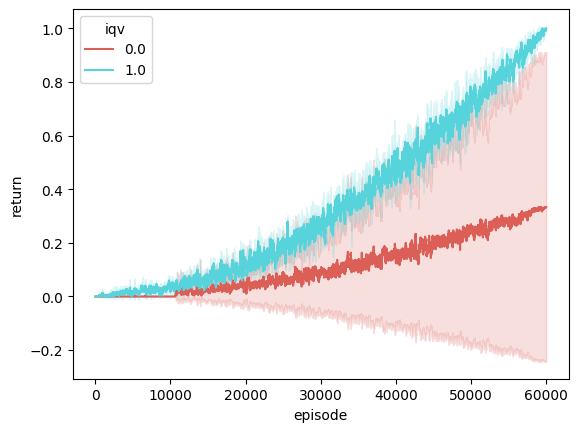

In [ ]:
plot(logs, x_key='episode', y_key='return', legend_key='iqv', estimator='mean', errorbar='sd')

### Questions

Using the above parameters (`init_q_values = [0., 1.]`, `epsilon=0.8`):
- Print the policy for agents with each of the `init_q_values`. (6 pts)
- For each initial Q value, do you converge to a successful policy (yes/no)? (4 pts)
  - **Answer:** no for 0 and yes for 1. 0 does not give an average return of 1.
- How does the performance compare between the initial Q values? Why is there a difference if any? (5 pts)
  - **Answer:**  Initial Q value of 1 is better. This is because the updated value on the Q function per each iteratioon, r+gamma*max[Q(s',a')]-Q(s,a), is different with init_q, making the convergence speed different.

If you set `epsilon=0.0` and `init_q_value=1`:
- How many steps does the policy take now? Why is it converging faster / slower as compared to higher value of initial_epsilon? (5 pts)
  - **Answer:** This took only around 150 episodes to get the averaged return of 1. This is because if epsilon is 0, the agent always explore with uniform policy and find the optimal path earlier.

In [ ]:
### TODO: add policy for agents with each of the init q_values. ########
agents[0].epsilon = 0
policy = np.array([agents[0].get_action(s) for s in range(64)])
print_policy(policy)
print()

agents[-1].epsilon = 0
policy = np.array([agents[-1].get_action(s) for s in range(64)])
print_policy(policy)
########################################################################

LLLLLLLL
LLLLLLLL
LLLLLLLL
LLLLLLLL
LLLLLLLL
LLLLLLLL
DLLLLLLL
RLLLLLLL

DDDDDLLL
RRRRDLLL
LLLLDLRD
DLLLLLLD
DLLLLLLL
DLULLLLU
DLULLULL
RLLULRDR


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Runs:   0%|          | 0/3 [00:00<?, ?it/s]

Episode:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode:   0%|          | 0/400 [00:00<?, ?it/s]

Episode:   0%|          | 0/400 [00:00<?, ?it/s]

DLUDDUDL
ULURDUDU
LLLLDLRU
DLLLLDLR
DLLLLDLU
DLUULLLR
DLUDLULL
RLLDDUDD


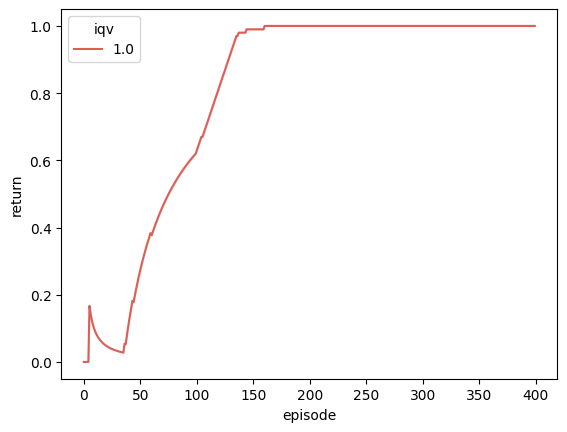

In [ ]:
logs_2, agent_2 = qlearning_sweep([1.], n_runs=3, max_episodes=400, epsilon=0.0)
plot(logs_2, x_key='episode', y_key='return', legend_key='iqv', estimator='mean', errorbar='sd')

agent_2[0].epsilon = 0
policy = np.array([agent_2[0].get_action(s) for s in range(64)])
print_policy(policy)

## Q-Learning Sample Complexity

Remember that we computed the *sample complexity* of Policy Iteration on 8x8 FrozenLake.

Modify the `QLearningEngine` to compute the sample complexity under the same definition (the number of actions the agent must take to learn an optimal policy, i.e., the number of calls to env.step).  For our purposes, we'll define an optimal policy as when the average episode reward is around 1.

**Questions:**

- What is the (rough) sample complexity of Q-Learning on 8x8 FrozenLake? (10 pts)
  - **Answer**: Below runs show that the number of calls to env.step is around 720k on average.
- Compare the computed sample complexity of Q-Learning to Policy Iteration.  Discuss why these numbers may be so different, or so similar (20 pts).
  - **Answer**: Q-learning has much more complexity because it does not have an information about the model, making it require a lot of episodes to get the optimal policy. Therefore it entails a large number of env.step calls.

In [ ]:
_, _ = qlearning_sweep([1.0], n_runs=3, max_episodes=60000, epsilon=0.8)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Runs:   0%|          | 0/3 [00:00<?, ?it/s]

Episode:   0%|          | 0/60000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


comp= 722613


Episode:   0%|          | 0/60000 [00:00<?, ?it/s]

comp= 717729


Episode:   0%|          | 0/60000 [00:00<?, ?it/s]

comp= 720469


# Bonus

Please enter the bonus code you get after filling out the survey https://forms.gle/sJnx7Rk1T1nsRYGx9 (10 pts)

**Bonus code**: value_or_policy

End of PSET!